In [2]:
%matplotlib widget
import numpy as np
import json, os, glob, numbers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

<a id='averaged_XAS'></a>
## Load data

In [7]:
pgroup = 'p22591'
Loaddir_name = ''

runlist = [56]
#runlist = np.arange(205, 225)
t0_offsets = [0]*len(runlist)
#t0_offsets = [50, 20]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [164]:
#Plot_correlations_scan(pgroup, Loaddir, run=runlist[0], path='raw', timescan=False, lowlim = 0.95)
#Plot_scan_2diodes(pgroup, Loaddir, run=runlist[0], threshold=0, path='raw', timescan=False)

In [8]:
withTT = True

###########################################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

#data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=False, t0_offset=t0_offsets)
#Plot_reduced_data(data1, scan, titlestring_stack1, withTT)
data2, titlestring_stack2 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=True, t0_offset=t0_offsets)
#Plot_reduced_data(data2, scan, titlestring_stack2, withTT)

readbacks = np.asarray(data2['readbacks'], dtype=object)

## [1D scan - fix delay](#1D-scan)
## [2D scan - delay & energy scan](#2D-scan)
## [Overlay curves](#Overlay-data)

# 1D scan

61 62 62
74978 shots out of 151467 survived


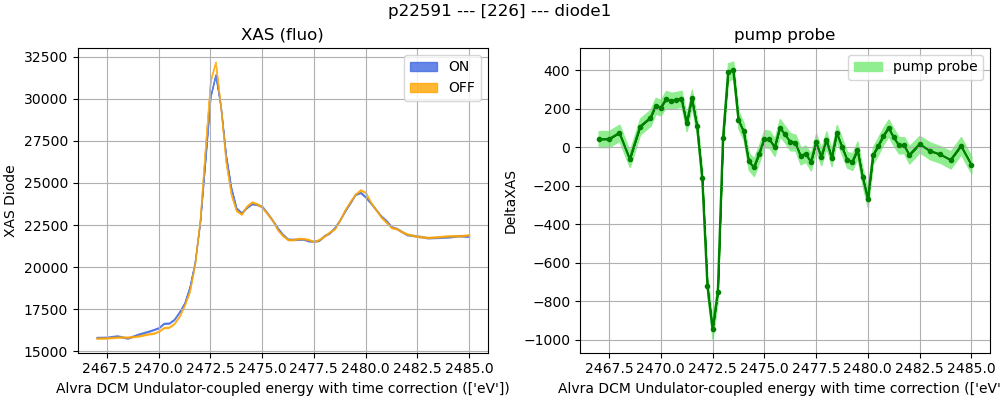

Data saved in /sf/alvra/data/p22591/work/Reduced_data//_singlerun/run226/
61 62 62
73953 shots out of 151467 survived


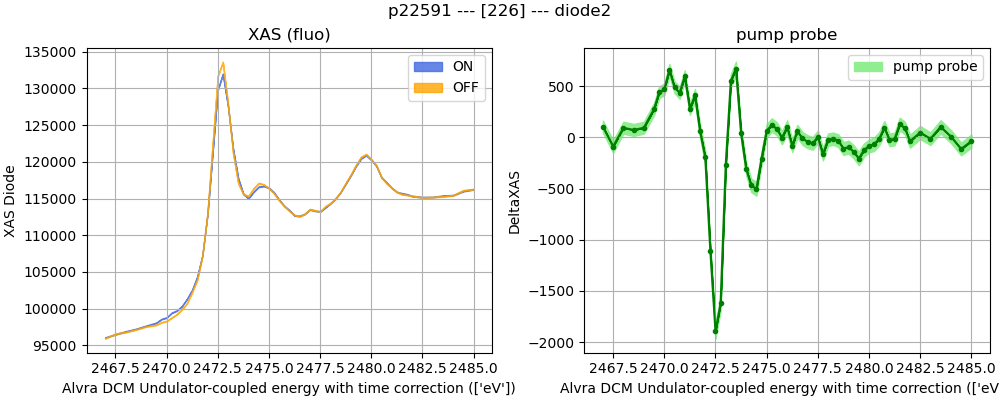

Data saved in /sf/alvra/data/p22591/work/Reduced_data//_singlerun/run226/


In [53]:
quantile1 = 0.7
quantile2 = 0.7

##############################################
rbk = np.array(readbacks[0], dtype=float)
indexNans = np.ones(len(rbk), dtype=bool)
           
results1 = Rebin_and_filter_energyscans_PP(data1, quantile1, rbk, threshold=0, n_sigma=5, raw=True)
plot_filtered_data(results1, scan, rbk, titlestring_stack1)
save_averaged_data(Loaddir, runlist, results1, rbk, "diode2", indexNans)

results2 = Rebin_and_filter_energyscans_PP(data2, quantile2, rbk, threshold=0.2, n_sigma=5, raw=True)
plot_filtered_data(results2, scan, rbk, titlestring_stack2)
save_averaged_data(Loaddir, runlist, results2, rbk, "diode2", indexNans)

In [ ]:
results2.keys()

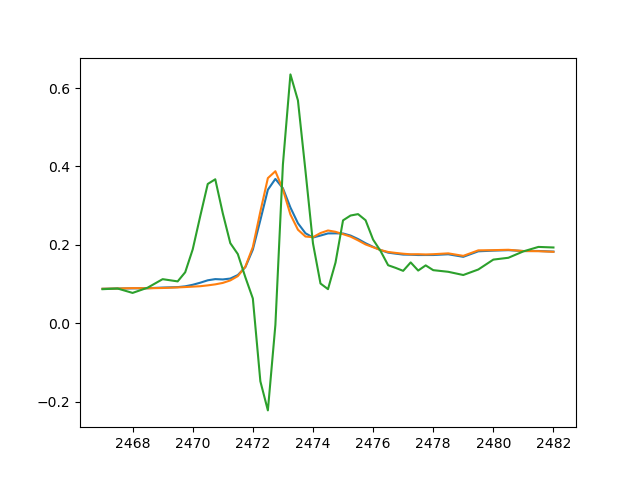

In [38]:
GS = results2['GS']
ES = results2['ES']
pp = results2['pp']
en = results2['energy']

b = 0.05

ext = 1/b * (pp) + GS

plt.figure()
plt.plot(en, ES)
plt.plot(en, GS)
plt.plot(en, ext)
plt.show()


In [6]:
#plot_shot_noise(results2, rbk, titlestring_stack2, quantile2)

In [7]:
#plot_shot_noise(results1, rbk, titlestring_stack1, quantile1)

## Average 2 diodes

Data saved in /sf/alvra/data/p22591/work/Reduced_data//_singlerun/run222/


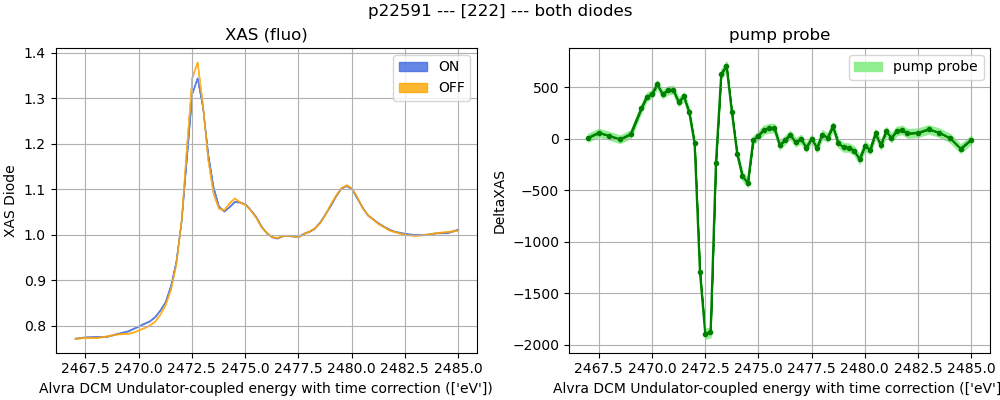

In [66]:
results1_norm = normalize_spectra (results1)
results2_norm = normalize_spectra (results2)

results_ave, titlestring_ave = average_two_diodes(results1_norm, results2_norm, titlestring_stack1)
save_averaged_data(Loaddir, runlist, results2, rbk, "both_diodes", indexNans)
plot_filtered_data(results_ave, scan, rbk, titlestring_ave)

## check I0 normalization

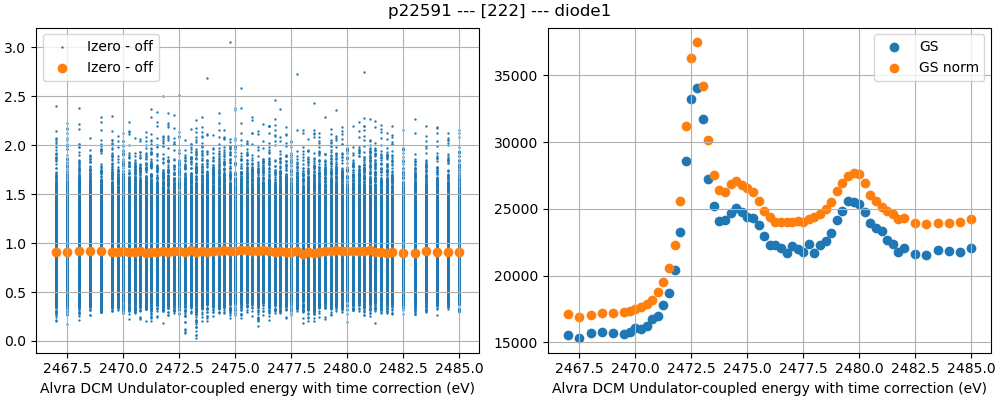

In [67]:
data = data1

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle(titlestring_stack1)

GS = np.array(data['unpump_1_raw'])
GS2 = np.array(data['unpump_2_raw'])
Izero_unpump = np.array(data['Izero_unpump'])
energy = np.array(data['scanvar'])
readbacks    = np.asarray(readbacks, dtype=object)

xlabel = scan.parameters['name'][0]
xunits = scan.parameters['units'][0]

ordered = np.argsort(np.asarray(energy))
peaks, what = find_peaks(np.diff(energy[ordered]))

Izero_unpump = Izero_unpump[ordered]

starts = np.append(0, peaks)
ends = np.append(peaks, None)

I0u = []
G = []

for s, e in zip(starts, ends):
    Izero_p = Izero_unpump[s:e]
    GSs = GS[s:e]
    I0u.append(np.mean(Izero_p))
    G.append(np.mean(GSs))
    
ax1.scatter (energy, Izero_unpump, label='Izero - off', s=0.5)
ax1.scatter(readbacks, I0u, label='Izero - off')
ax1.set_xlabel("{} ({})".format(xlabel, xunits))

ax3.scatter(readbacks, G, label='GS')
ax3.scatter(readbacks, np.array(G)/np.array(I0u), label='GS norm')
ax3.set_xlabel("{} ({})".format(xlabel, xunits))

ax1.legend(loc="best")
ax1.grid()

ax3.legend(loc="best")
ax3.grid()

plt.show()

# 2D scan

In [9]:
quantile = 0.95

withTT = True

binsize = 50
min_delay = -300
max_delay = 1100

(variable_bins_delay, numbins) = (False, 100)


##############################################
rbk = np.array(readbacks[0], dtype=float)

#results1 = Rebin_and_filter_2Dscans(data1, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=5, varbin_t=variable_bins_delay, numbins=numbins)
results2 = Rebin_and_filter_2Dscans(data2, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=5, varbin_t=variable_bins_delay, numbins=numbins)

#pp_TT = (results1['pp']+results2['pp'])/2
pp_TT = results2['pp']

Delay_fs_TT = results2['Delay']
#pp_TT       = results['pp']

47 48 27
Time delay axis rebinned with TT data
214291 shots out of 356340 survived (60.14%)


In [168]:
results2.keys()


dict_keys(['GS', 'ES', 'pp', 'err_pp', 'Delay', 'howmany'])

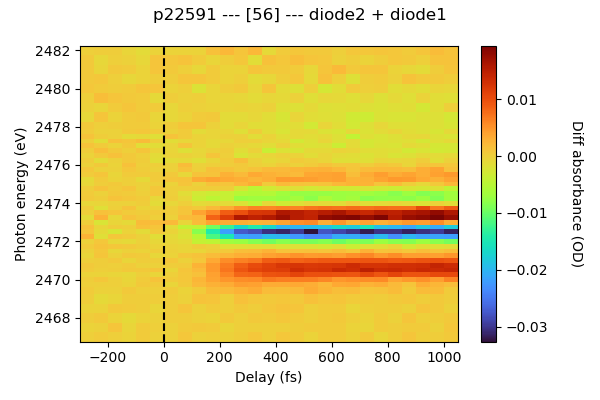

In [11]:
import matplotlib.colors as colors
baseline = np.average(pp_TT[:,0:2], axis=1)
#baseline = np.average(GS[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

# Delay_fs_TT_2 = Delay_fs_TT[~np.isnan(Delay_fs_TT)]
# pp_TT = pp_TT[:,~np.isnan(Delay_fs_TT)]

plt.figure(figsize=(6, 4))
#plt.rcParams.update({'font.size': 15})
#plt.suptitle(titlestring_stack1)
plt.suptitle(titlestring_stack2+' + diode1')
#plt.title(runlist)

vmin = -0.03
vmax = 0.015
n = 30
levels = np.linspace(vmin, vmax, n+1)

#plt.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='turbo',vmin=vmin, vmax=vmax)
# plt.pcolormesh(Delay_fs_TT, rbk, (pp_TT-baseline)/results2['GS'], cmap='turbo')
plt.pcolormesh(Delay_fs_TT, rbk, (pp_TT-baseline), cmap='turbo')
# plt.pcolormesh(Delay_fs_TT, rbk, results2['ES'] - results2['GS'], cmap='turbo')
#plt.contourf(pp_TT-baseline, cmap='seismic', levels=levels, extent=[Delay_fs_TT[0], Delay_fs_TT[-1], rbk[0], rbk[-1]], extend='both')
#plt.pcolormesh(Delay_fs_TT+0, rbk, ES-baseline, cmap='jet')#, vmin=-0.004, vmax = 0.011)

#plt.pcolormesh(pp_TT-baseline, cmap='bwr', vmin=-0.1, vmax = 0.1)
#plt.ylabel('{} ({})'.format(_averagedscan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('Photon energy (eV)')

cbar = plt.colorbar(fraction=0.15)
cbar.set_label('Diff absorbance (OD)', rotation=270, labelpad=25)
#plt.colorbar()

plt.xlabel('Delay (fs)')
plt.axvline(x = 0, color = 'k', linestyle = '--')
#plt.grid()
plt.tight_layout()
plt.show()

In [14]:
np.save('XANES_sample3_2D_56_0p95.npy',{'data_c':pp_TT-baseline,'TD':Delay_fs_TT,'WL':rbk,'GS':results2['GS'],'ES':results2['ES']})

8
14
18
30


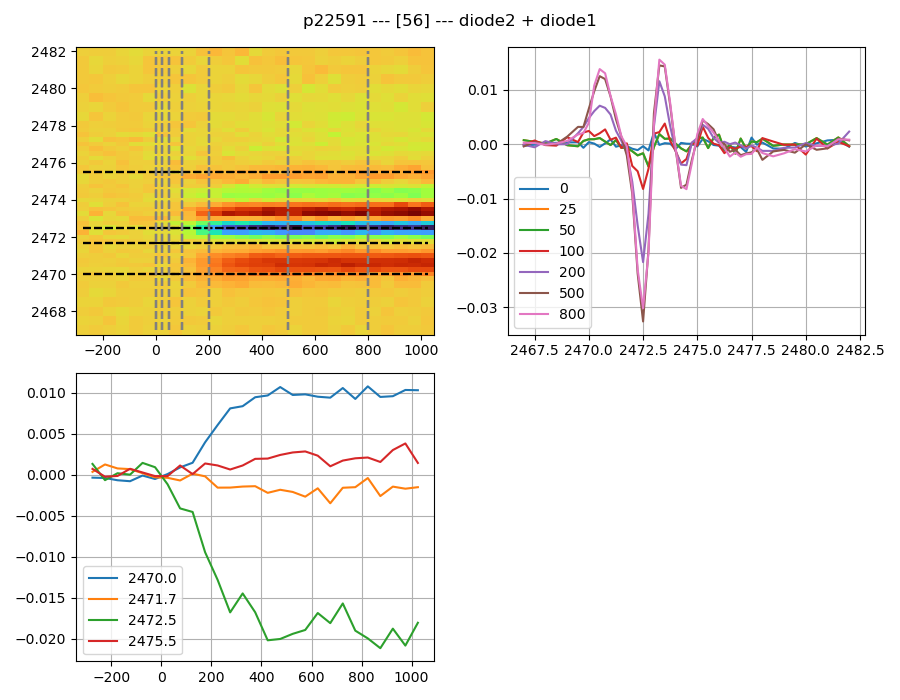

In [12]:
delay_integration = 50
energy_bin = 0.5

energylist = [2470.0,2471.7,2472.5, 2475.5]
delayslist = [0,25,50,100,200,500,800]

import matplotlib.colors as colors
norms = colors.LogNorm(vmin=0, vmax=1, clip=False)

f = plt.figure(figsize=(9,7))
plt.suptitle(titlestring_stack2+' + diode1')
#plt.suptitle('diode1 + diode2')
gs = gridspec.GridSpec(2,2, height_ratios=[2,2], width_ratios=[2,2])
ax1 = plt.subplot(gs[0,0])
#ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='seismic',vmin=vmin, vmax=vmax)
# ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='turbo',vmin=vmin, vmax=vmax)
ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='turbo')

#ax1.pcolormesh(Delay_fs_TT, rbk, np.log(pp_TT-baseline), cmap='jet')#, norm=norms)#,vmin=vmin, vmax=vmax)
ax1.hlines(energylist, ls='--', color='black', xmin=0, xmax=100)
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[0,1])

for energy in energylist:
    index_energy = np.arange(len(rbk))[(np.array(rbk) > energy)][0]
    print (index_energy)
    ax1.hlines(energylist, ls='--', color='black', xmin=min(Delay_fs_TT), xmax=max(Delay_fs_TT))
    #cut_e = np.mean(np.array(pp_TT-baseline)[np.arange(index_energy-energy_bin,index_energy+energy_bin+1),:], axis=0)
    cut_e = np.array(pp_TT-baseline)[index_energy,:]
    ax2.plot(Delay_fs_TT, cut_e, label=energy)
    #ax2.plot(Delay_fs_TT, np.array(pp_TT-baseline)[index_energy], label=energy)
    ax2.legend(loc='best')

for time in delayslist:
    index_delay = np.arange(len(Delay_fs_TT))[(np.array(Delay_fs_TT) > time)][0]
    ax1.vlines(delayslist, ls='--', color='gray', ymin=min(rbk), ymax=max(rbk))
    #cut_d = np.mean(np.array(pp_TT-baseline)[:,index_delay-delay_integration//binsize:index_delay+delay_integration//binsize], axis=1)
    cut_d = np.array(pp_TT-baseline)[:,index_delay]
    ax3.plot(rbk, cut_d, label=time)
    #ax3.plot(rbk,np.array(pp_TT-baseline)[:,index_delay],label =time)
    #ax3.vlines(7121.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')
    #ax3.vlines(7125.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')

    ax3.legend(loc='best')
#ax1.set_xscale('log')
ax2.grid()
ax3.grid()
plt.tight_layout()

In [161]:
np.save('XANES_sample1_2D_78_0p95.npy',{'data_c':pp_TT-baseline,'WL':rbk,'TD':Delay_fs_TT})

## Time-zero alignment - signal at 7124 eV

In [24]:
pgroup = 'p22250'
Loaddir_name = ''

#runlist = np.arange(41, 45)
runlist = [149]

t0_offsets = [0]*len(runlist)   # run this later to check it is aligned
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

IndexError: list index out of range

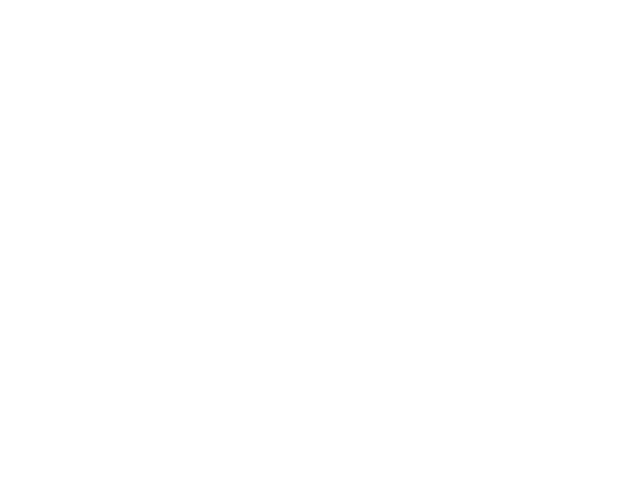

In [25]:
switch_diodes = False   #False for Diode 1, True for diode 2

quantile = 0.9

withTT = True
binsize = 10
min_delay = -75
max_delay = 250

(variable_bins_delay, numbins) = (False, 100)

energycut = 7124
#baseline = np.average(pp_TT[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

plt.figure()
offset = []           # uncomment for first run to check the time-zero values of each run
for index, run in enumerate(runlist):
    #print (run)
    t0_off = [t0_offsets[index]]
    data = {}
    globals().update(data)
    data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, [run], switch_diodes=switch_diodes, t0_offset=t0_off)
    
    readbacks = np.asarray(data1['readbacks'], dtype=object)
    rbk = np.array(readbacks[0], dtype=float)
    globals().update(data)

    results = Rebin_and_filter_2Dscans(data1, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=3, varbin_t=variable_bins_delay, numbins=numbins)

    pp_TT = results['pp']
    Delay_fs_TT = results['Delay']

    index_energy = np.arange(len(rbk))[(np.array(rbk) > energycut)][0]
    cut = np.mean(np.array(pp_TT-baseline)[index_energy-1:index_energy+1, :], axis=0)
    cut_derivative = gaussian_filter1d(cut, 1, order = 1)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(cut_derivative))
    Delay_fs_TT = Delay_fs_TT[index]
    cut_derivative=  cut_derivative[index]
    
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, cut_derivative, p0 = [50, 0.1, 50, 0])
    #print (index_energy)
   # plt.plot(Delay_fs_TT, alignment, label=run) # comment for first run
    plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green')
    offset.append(-parameters_M2[0])           # comment after checking time-zero values for each run and run again this cell
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

In [98]:
offset

NameError: name 'offset' is not defined

## Overlay data

In [313]:
# pgroup = 'p22591'

runlist2load = [191,192,195]

#runlist2load = [78, 34]
#runlist2load = [21, 24, 28, 29, 30, 33, 34, 52, 53, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 74, 75, 76, 77]

Loaddir_folder = '_singlerun' #_single #_multiruns
whichdiode = 'diode2'  #both_diodes
# whichdiode = 'diode1'  #both_diodes

whichaverage = [0]*len(runlist2load)
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist2load)
print ('Will load {} runs: {} from {}'.format(len(runlist2load), runlist2load, Loaddir))
check = []
for i, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
    try:
        check.append(glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [191, 192, 195] from /sf/alvra/data/p22591/work/Reduced_data/_singlerun/


['/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run191/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run192/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run195/run_array_diode2.npy']

/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run191/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run192/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run195/run_array_diode2.npy


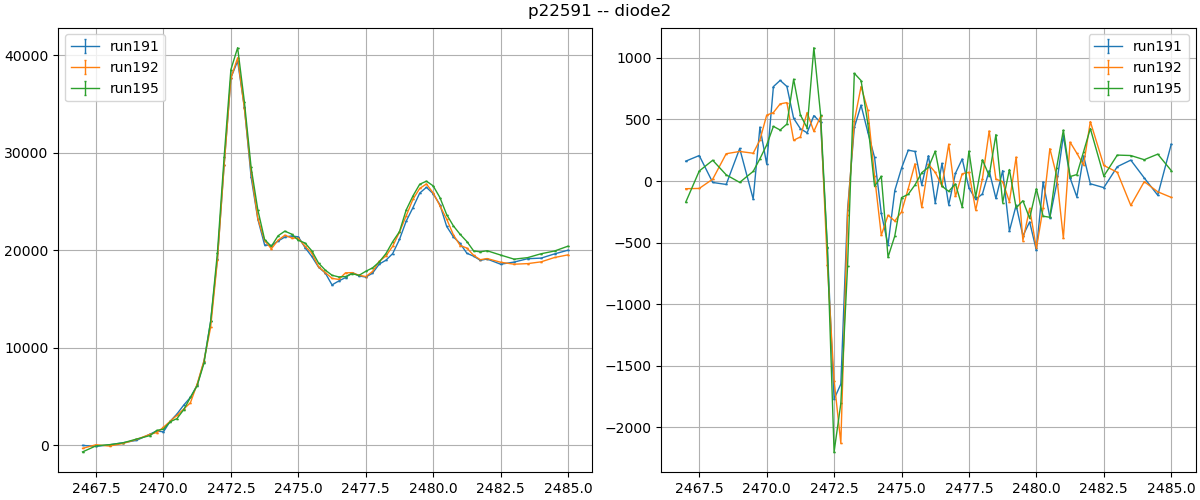

In [315]:
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode1':
    switchdiode=False
else:
    switchdiode=True
peak = []
lab=['100 fs','200 fs', '500fs', '1ps', '2ps']#, '595nm 100fs','595nm 350fs', '330ps','1ns','350fs']
# scale = [1.75,2.6,3.5,1,1]*len(runlist2load)
scale = [1]*len(runlist2load)

for index, (run, avg) in enumerate(zip(runlist2load, whichaverage)):
#for index, run in enumerate(runlist2load):
    filepath = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[avg]
    print(filepath)
    run_array = np.load(filepath, allow_pickle=True).item()
    for key in run_array.keys():
        runname  = run_array[key]["name"].split('-')[0]
        GS       = run_array[key]["GS"]
        err_GS   = run_array[key]["err_GS"]
        
        ES       = run_array[key]["ES"]
        err_ES   = run_array[key]["err_ES"]
        pp_rebin = run_array[key]["pp"]
        err_pp   = run_array[key]["err_pp"]
        rbk      = run_array[key]["readbacks"]
    # print(index)
    peak.append(max(GS)-np.mean(GS[:5]))
    ax1.errorbar(rbk, ES- np.mean(GS[:5]), 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+'-'+str(lab[index]))
    # ax3.errorbar(rbk, pp_rebin*scale[index], 0, lw=1,markersize=0,capsize=1,capthick=1,
    #                elinewidth=1,label=runname)#+'-'+str(lab[index]))
    ax3.errorbar(rbk, pp_rebin, 0, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+'-'+str(lab[index]))
    
plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
ax1.legend(loc = 'upper left')
ax1.grid()
ax3.legend(loc = 'upper right')
ax3.grid()

In [197]:
ttime = []
ff = []
for run in runlist2load:
    f = glob.glob('/sf/alvra/data/p22588/raw/*{:04d}*/meta/scan.json'.format(run))[0]
    print (f)
    ff.append(f)
    #ttime.append(timestamp_hms(f))
    ttime.append(creation_date(f))

/sf/alvra/data/p22588/raw/run0021-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0024-PtLQ_XANES_1ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0028-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0029-PtLQ_XANES_100fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0030-PtLQ_XANES_500fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0033-PtLQ_XANES_1ps_1uJ_001/meta/scan.json
/sf/alvra/data/p22588/raw/run0034-PtLQ_XANES_1ps_1uJ_002/meta/scan.json
/sf/alvra/data/p22588/raw/run0052-PtLQ_XANES_200fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0053-PtLQ_XANES_350fs_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0055-PtLQ_XANES_5ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0058-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0059-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0060-PtLQ_XANES_10ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/run0061-PtLQ_XANES_20ps_1uJ/meta/scan.json
/sf/alvra/data/p22588/raw/

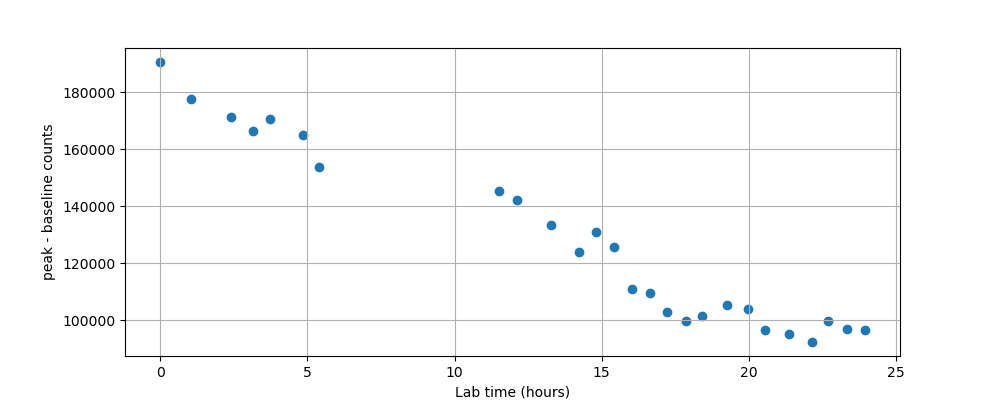

In [198]:
plt.figure(figsize=(10,4))
plt.scatter((np.array(ttime)-np.array(ttime)[0])/3600, peak)
#plt.scatter(ttime, peak)
#plt.gcf().autofmt_xdate()


plt.ylabel('peak - baseline counts')
plt.xlabel('Lab time (hours)')
plt.grid()
plt.show()

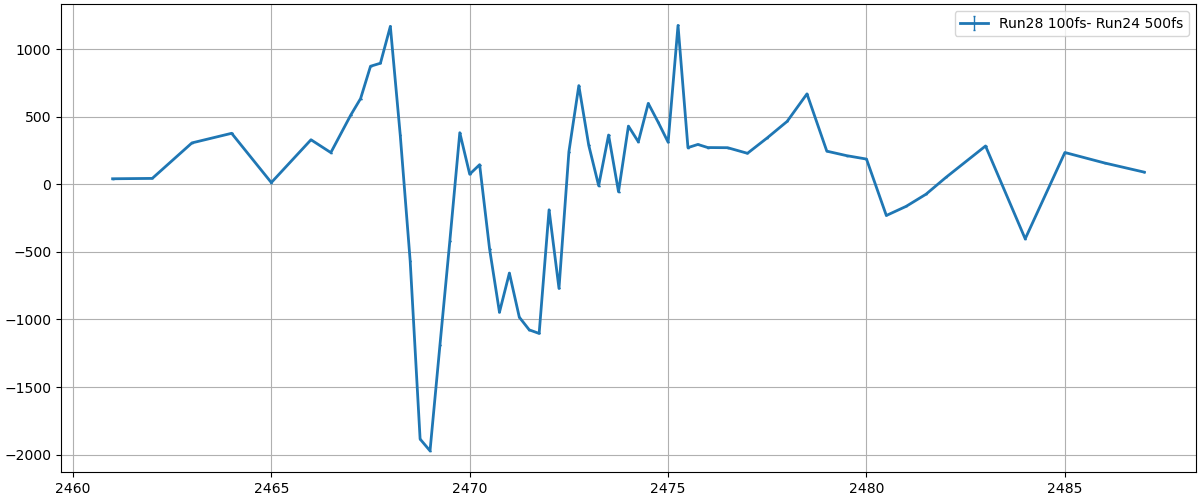

In [15]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
if whichdiode=='diode1':
    switchdiode=False
else:
    switchdiode=True

run1 = 28
run2 = 24

label1 = '100fs'
label2 = '500fs'

filepath1 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run1, whichdiode))[0]
filepath2 = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run2, whichdiode))[0]
run_array1 = np.load(filepath1, allow_pickle=True).item()
run_array2 = np.load(filepath2, allow_pickle=True).item()

for key in run_array1.keys():
        
        runname  = run_array1[key]["name"].split('-')[0]
        GS       = run_array1[key]["GS"]
        err_GS   = run_array1[key]["err_GS"]
        ES       = run_array1[key]["ES"]
        err_ES   = run_array1[key]["err_ES"]
        pp_rebin1 = run_array1[key]["pp"]
        err_pp   = run_array1[key]["err_pp"]
        rbk1     = run_array1[key]["readbacks"]

for key in run_array2.keys():
        runname  = run_array2[key]["name"].split('-')[0]
        GS       = run_array2[key]["GS"]
        err_GS   = run_array2[key]["err_GS"]
        ES       = run_array2[key]["ES"]
        err_ES   = run_array2[key]["err_ES"]
        pp_rebin2 = run_array2[key]["pp"]
        err_pp   = run_array2[key]["err_pp"]
        rbk2     = run_array2[key]["readbacks"]

# plt.show()

# plt.show()
# plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
# ax1.legend(loc = 'upper left')
# ax1.grid()
# ax3.legend(loc = 'upper left')
# ax3.grid()



ax1.errorbar(rbk1, pp_rebin1-pp_rebin2, 0, lw=2,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label = 'Run'+str(run1)+' '+label1 +'- Run'+str(run2)+' '+label2)
ax1.legend()
plt.grid()
plt.show()